# Telco Customer Churn

Objetivo: prever se o cliente vai cancelar (Churn = Yes) ou não (Churn = No).

Fluxo:
1) EDA básica (distribuição do churn, nulos, relações simples)
2) Pré-processamento (OneHotEncoder p/ categóricas, StandardScaler p/ numéricas)
3) Split estratificado (train/test)
4) Balanceamento com SMOTE (dados desbalanceados)
5) Modelos: Logistic Regression (baseline) e Random Forest (comparativo)
6) Avaliação: classification_report, confusion_matrix, ROC AUC


## Importação de Bibliotecas

In [2]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.model_selection import train_test_split  
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.impute import SimpleImputer  
from sklearn.pipeline import Pipeline  
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score  
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier  

from imblearn.over_sampling import SMOTE  

# Configurações visuais e de reprodutibilidade
RANDOM_STATE = 42  
np.random.seed(RANDOM_STATE)
sns.set(font_scale=1.0) 
plt.rcParams["figure.figsize"] = (7, 4)  


## Carregando Arquivo

In [3]:
DATA_PATH = r"C:\Users\marcu\Desktop\PROJECT-CustomChurn\archive (1)\WA_Fn-UseC_-Telco-Customer-Churn.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Não encontrei o arquivo em: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Limpeza mínima e alvo

In [4]:
df = df.copy()
df.columns = [c.strip() for c in df.columns]

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")

for id_col in ("customerID", "CustomerID", "id"):
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

if "Churn" not in df.columns:
    raise KeyError("Coluna 'Churn' não encontrada no dataset.")
y = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

X = df.drop(columns=["Churn"])
X.shape, y.mean()


((7043, 19), np.float64(0.2653698707936959))

## AED: distribuição e nulos

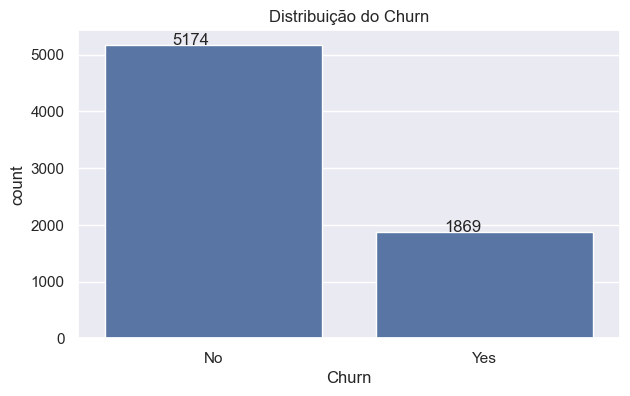

Proporção de churn (1): 0.2654


TotalCharges    0.001562
dtype: float64

In [5]:
ax = sns.countplot(x=y.map({0:"No", 1:"Yes"}))
ax.set_title("Distribuição do Churn")
ax.set_xlabel("Churn")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+3))
plt.show()

print("Proporção de churn (1):", y.mean().round(4))

missing = X.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(15)
